In [1]:
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
def import_labelled_data(path="data/labelled/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data


print("Loading data...")

data = import_labelled_data(
    path="../../data/level-0.5/data.json"
)

print("Data loaded.")


# data = data.sample(2500)

data = data.sample(frac=1).reset_index(drop=True)

data.info()
data.head()

Loading data...
Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           2500 non-null   object
 1   text          2500 non-null   object
 2   relevance     2500 non-null   object
 3   multiclasses  2500 non-null   object
dtypes: object(4)
memory usage: 78.2+ KB


,url,text,relevance,multiclasses
0,https://www.conservationevidence.com/individua...,A replicated controlled study of former agricu...,relevant,[Farmland]
1,https://region8.bfar.da.gov.ph/wp-content/uplo...,re Ag ricultu pa of rtment De 8 RESOURCES AQUA...,irrelevant,[]
2,https://www.conservationevidence.com/individua...,"A replicated, before-and-after study in 2010 o...",relevant,"[Animals Ex-Situ, Captivity]"
3,https://www.conservationevidence.com/individua...,"A replicated, before-and-after study in 2005 a...",relevant,[Bats]
4,https://apps.worldagroforestry.org/downloads/P...,One year after Tsunami Aceh The coastal areas ...,irrelevant,[]


In [3]:
def train_test_split(x, y=None, test_size=0.2,shuffle=False):
    if shuffle:
        x = x.sample(frac=1).reset_index(drop=True)
    split = int(len(x) * (1 - test_size))
    xTrain, xTest = x.iloc[:split], x.iloc[split:]
    if y is not None:
        yTrain, yTest = y.iloc[:split], y.iloc[split:]
        return xTrain, xTest, yTrain, yTest
    return xTrain, xTest


trainData, testData = train_test_split(data, test_size=0.2) # already shuffled above

In [4]:
trainData.head()

,url,text,relevance,multiclasses
0,https://www.conservationevidence.com/individua...,A replicated controlled study of former agricu...,relevant,[Farmland]
1,https://region8.bfar.da.gov.ph/wp-content/uplo...,re Ag ricultu pa of rtment De 8 RESOURCES AQUA...,irrelevant,[]
2,https://www.conservationevidence.com/individua...,"A replicated, before-and-after study in 2010 o...",relevant,"[Animals Ex-Situ, Captivity]"
3,https://www.conservationevidence.com/individua...,"A replicated, before-and-after study in 2005 a...",relevant,[Bats]
4,https://apps.worldagroforestry.org/downloads/P...,One year after Tsunami Aceh The coastal areas ...,irrelevant,[]


In [5]:
from LogisticRegressionClassifier import LogisticRegressionClassifier

# Vectorization on 2500 articles takes roughly
# Training is instant

print('Estimated time to train on full dataset: ', 67 / 2500 * len(data), ' seconds')


logistic = LogisticRegressionClassifier()
logistic.train(trainData)

Estimated time to train on full dataset:  67.0  seconds


In [7]:
def eval(classifier):
    predYBools, predYProbabilities = classifier.predict_threshold(testData,threshold=0.5)
    return testData['relevance'].map({'relevant':1, 'irrelevant': 0}),predYBools, predYProbabilities


print('Estimated articles processed per second: ', 3857 / 51)
print(f'Estimated time to predict on {len(testData)} articles: ', 51 / 3857 * len(testData), ' seconds')

Estimated articles processed per second:  75.62745098039215
Estimated time to predict on 500 articles:  6.611355976147265  seconds


In [8]:
trueYInts, predYBools, predYProbabilities = eval(logistic)
# took 10.4s for 500 articles

In [9]:
type(trueYInts), type(predYBools), type(predYProbabilities)

(pandas.core.series.Series, numpy.ndarray, numpy.ndarray)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score

def calculate_metrics(trueYInts, predYBools, predYProbabilities):
    return {
            "accuracy": accuracy_score(trueYInts, predYBools),
            "f1": f1_score(trueYInts, predYBools, average='macro',zero_division=0),
            "precision": precision_score(trueYInts, predYBools, average='macro',zero_division=0),
            "confusion_matrix": confusion_matrix(trueYInts, predYBools),
            "predictions": logistic.boolPredictionsToLabels(predYBools.astype('bool').astype(f'<U{len("irrelevant")}')),
            "probabilities": predYProbabilities[:,1]
        }


# need the f'<U{len("irrelevant")}' to ensure the strings don't get
# truncated to the same length as 'False'
# so we set the max length to the length of 'irrelevant'



def format_output(results):
    print(f"Accuracy: {results['accuracy']} \t F1: {results['f1']} \t Precision: {results['precision']} \t")
    print("\n\n")

In [11]:
results = calculate_metrics(trueYInts, predYBools.astype('int32'), predYProbabilities)

format_output(results)

Accuracy: 0.994 	 F1: 0.9939032073194028 	 Precision: 0.9946996466431095 	





In [12]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 2000 to 2499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           500 non-null    object
 1   text          500 non-null    object
 2   relevance     500 non-null    object
 3   multiclasses  500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB


In [14]:
testData = testData.assign(predictions=results['predictions'], score=results['probabilities'])


In [15]:
testData.info()
testData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 2000 to 2499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           500 non-null    object 
 1   text          500 non-null    object 
 2   relevance     500 non-null    object 
 3   multiclasses  500 non-null    object 
 4   predictions   500 non-null    object 
 5   score         500 non-null    float64
dtypes: float64(1), object(5)
memory usage: 23.6+ KB


,url,text,relevance,multiclasses,predictions,score
2000,https://budget.finance.go.ug/sites/default/fil...,LG Draft Budget Estimates 2024/25 VOTE: 708 Ka...,irrelevant,[],irrelevant,0.043956
2001,https://documents1.worldbank.org/curated/ru/69...,dd ee zz ii rr oo hh tt uu AA ee rr uu ss oo l...,irrelevant,[],irrelevant,0.044929
2002,https://muntinlupacity.gov.ph/wp-content/uploa...,REPUBLIKA NG PILPINAS PAMAHALAAI{G LUNGSOD NG ...,irrelevant,[],irrelevant,0.074044
2003,https://documents1.worldbank.org/curated/en/85...,d e z Pearson et al. BMC Public Health (2018) ...,irrelevant,[],irrelevant,0.063588
2004,https://www.conservationevidence.com/individua...,Manage wetlands or ponds by grazing or cutting...,relevant,[Insects],relevant,0.929197


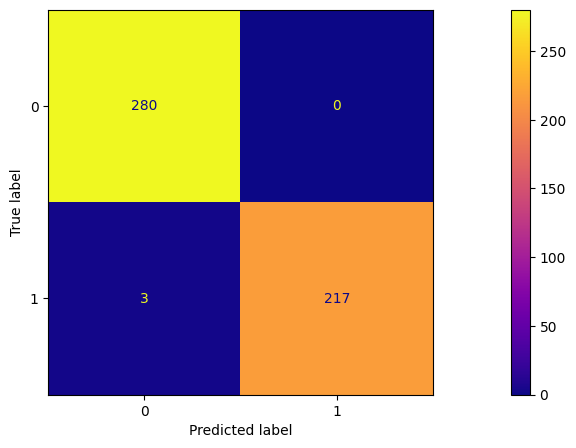

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(testData['relevance'], testData['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()



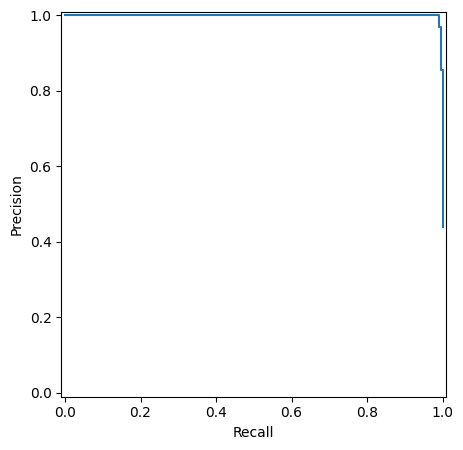

In [17]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(trueYInts, predYProbabilities[:,1])

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=axs)

plt.show()


In [28]:
# save logistic regression model

import pickle
import os

if len(data) <= 15000:
    path = 'models/dev/LogisticRegression.pkl'
else:
    path = 'models/LogisticRegression.pkl'

with open(path, 'wb') as f:
    pickle.dump(logistic, f)

